# Ecometrix Take Home

You will be given a PDF document that contains both textual and graphical data. Your task is to:

* Extract the textual and graphical information from the PDF pages.
* Convert the extracted graphical data (such as charts or graphs) into a structured, queryable format.
* Implement a system where users can ask questions and receive meaningful responses based on the extracted data.


Requirements:
* Document your approach and display your results in a Jupyter notebook (.ipynb)
* Your solution should allow users to query both the extracted text and any data that was derived from the graphical elements (such as tables).
* Provide brief explanations of your approach, choices made, and any challenges you encountered.

---

## Solution Overview

To tackle the the requirements listed above I will leverage a **Multimodal RAG** (Retrieval Augmented Generation). An overall architecture is shown below:
![architecture overview](diagrams/architecture%20overview.png)

The diagram starts with the input PDF file. The unstructured Python library is used to extract both textual and image content from the document. Text and image summarization models then generate summaries and captions based on the extracted content. These outputs are stored in a vector database, enabling retrieval in response to user queries. Additionally, a general-purpose LLM can be used to generate answers based on the top documents retrieved from the vector database. This entire multimodal RAG workflow is made possible through extensive use of the LangChain framework, which orchestrates the components for document loading, embedding, retrieval, and response generation.

---

## Environment Setup
**Python**
- Create virtual environment and activate \
`python -m venv .venv` \
`.venv/Scripts/activate`

- Install dependencies \
`pip install -r requirements.txt`



**Unstructured Python Library dependency to properly read PDF**
- Download [Poppler](https://github.com/oschwartz10612/poppler-windows/releases) extract and put bin directory to your `PATH`
- Download and install [Tesseract](https://github.com/UB-Mannheim/tesseract/wiki) put bin directory to your `PATH`

**Ollama Setup (Will act as LLM generator)**
- Install [Ollama](https://ollama.com/download)
- Get a model \
`ollama pull <model_name>` \
e.g. `ollama pull gemma2`
- List models \
`ollama list`

---

## Directory Structure

- `\data\` - Contains the singular PDF file
- `\diagrams\` - Contains supplementary images and drawio diagram
- `helper.py` – Contains utility functions to keep the notebook clean and organized
- `rag_ecometricx.ipynb` - Main jupyter notebook
- `README.md` - README
- `requirements.txt` - Python dependencies

## Python Imports

In [1]:
import base64
import uuid
from base64 import b64decode
from io import BytesIO

from IPython.display import HTML, Image, Markdown, display
from transformers import pipeline

from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnableLambda, RunnablePassthrough
from langchain_core.messages import HumanMessage
from langchain_community.embeddings import OllamaEmbeddings
from langchain_community.llms import Ollama
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_chroma import Chroma
from langchain_ollama import OllamaLLM
from langchain.schema.document import Document
from langchain.storage import InMemoryStore
from langchain.retrievers.multi_vector import MultiVectorRetriever

from unstructured.partition.pdf import partition_pdf
from helper import *

In [2]:
# !pip install -Uq "unstructured[all-docs]" pillow lxml pillow
# !pip install -Uq chromadb tiktoken
# !pip install -Uq langchain langchain-community langchain-openai langchain-groq
# !pip install -Uq python_dotenv
# !pip install -Uq tqdm ipywidgets 
# !pip install -Uq langchain_ollama langchain_huggingface

## Set Important Variables
- **`pdf_file_path`**: Path to the input PDF file.  
- **`caption_model_name`**: Model used for generating captions from images.  
- **`text_embedding_model_name`**: Model for embedding text into vectors for retrieval.  
- **`ollama_model_name`**: Ollama model used for both embedding and answering questions.  

In [3]:
pdf_file_path = "data/test_info_extract.pdf"
caption_model_name = "microsoft/git-base"
text_embedding_model_name = "BAAI/bge-large-en-v1.5"
ollama_model_name = "gemma3"

## Getting Chunks from PDF input

This section uses the unstructured library's `partition_pdf` function to split a PDF into structured chunks (like images and text) for further processing for use in RAG (Retrieval-Augmented Generation)

In [4]:
chunks = partition_pdf(
    filename=pdf_file_path,
    infer_table_structure=True,            # extract tables
    strategy="hi_res",                     # mandatory to infer tables
    extract_image_block_types=["Image"],   # Add 'Table' to list to extract image of tables
    extract_image_block_to_payload=True,   # if true, will extract base64 for API usage
    chunking_strategy="by_title",          # or 'basic'
    max_characters=10000,                  # defaults to 500
    combine_text_under_n_chars=2000,       # defaults to 0
    new_after_n_chars=6000,
)

The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


Check data type of chunks, expecting:
- `unstructured.documents.elements.CompositeElement` (Text and Image)
- `unstructured.documents.elements.Table` (Tables if there are any)

In [5]:
set([str(type(el)) for el in chunks])

{"<class 'unstructured.documents.elements.CompositeElement'>"}

Looks like we only have images and texts on our chunks. Let's try to see the number of chunks we have:

In [6]:
len(chunks)

1

I think this is expected as we only have one short PDF file. Let's look at the unique specific types we have under `CompositeElement`:

In [7]:
set([type(element).__module__ + "." + type(element).__name__ for element in chunks[0].metadata.orig_elements])

{'unstructured.documents.elements.Image',
 'unstructured.documents.elements.NarrativeText',
 'unstructured.documents.elements.Text',
 'unstructured.documents.elements.Title'}

It`s composed of tmages and various textual types.

---

## Segregating Images and Texts

### Separating Tables from Texts

Since there are no tables tables chunk is empty and so most of the contents will be inside `texts`

In [8]:
tables = []
texts = []

for chunk in chunks:
    if "Table" in str(type(chunk)):
        tables.append(chunk)

    if "CompositeElement" in str(type((chunk))):
        texts.append(chunk)

In [9]:
print(len(tables))
print(len(texts))

0
1


### Getting Images

Getting images from our chunk we have 11 images extracted

In [10]:
images = get_images_base64(chunks)

In [11]:
len(images)

11

Displaying an image for us to inspect

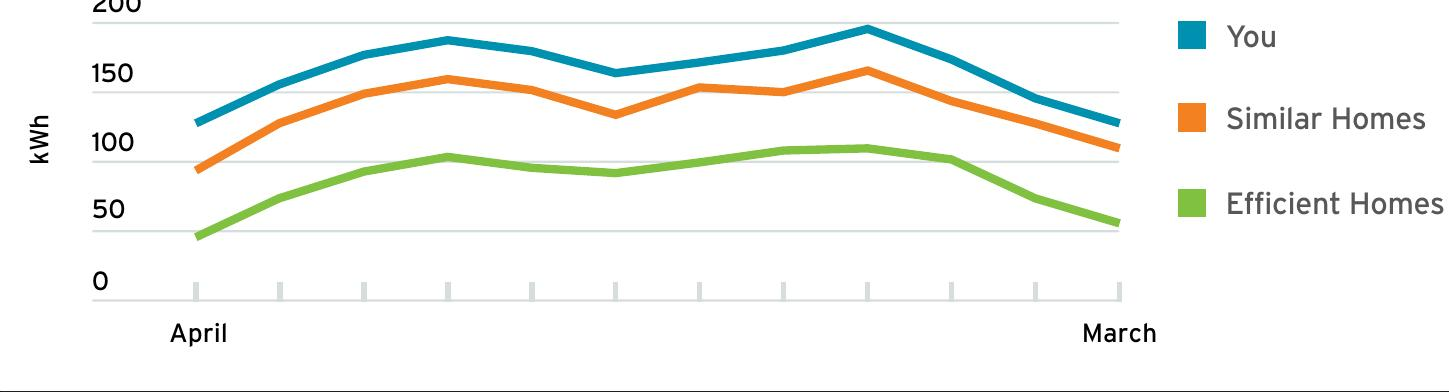

In [12]:
display_base64_image(images[7])

---

## Text Summary and Image Caption

### Text Summary

For the text summary, I’ll use the original text itself as its own description since the content is brief and doesn't require further summarization.

In [13]:
text_summary = [i.text for i in chunks]

### Image captioning

For image captioning, I will be using a HuggingFace model ([microsoft/git-base](https://huggingface.co/microsoft/git-base)) to do simple image captioning, this is not really a super good model for captioning and describing images like charts but its good enough for now as some image to text models are behind a pay wall like OpenAI which can be better in captioning.

In [14]:
captioner = pipeline(
    "image-to-text", 
    model="microsoft/git-base",
    device=0,
    use_fast=True
)
img_cap_list = []
for image in images:
    caption = captioner(image)[0]["generated_text"]
    img_cap_list.append(caption)

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Device set to use cpu


Checking the caption on the displayed image of a chart earlier:

In [15]:
img_cap_list[7]

'a line graph showing the line of the line.'

It's kinda good but not good enough. For the purpose of getting a good retreival in the later steps lets just assume our captioning model did great and made this caption:

In [16]:
img_cap_list[7] = "line graph showing electricity consumption"

## Setting Up the Vector and Document Store

Here, we use ChromaDB as the vector store and an in-memory store for the documents. Each summary and corresponding document will be assigned a doc_id to support retrieval later on.

In [17]:
embeddings = HuggingFaceEmbeddings(model_name='BAAI/bge-large-en-v1.5')

vector_store = Chroma(
    collection_name="rag_vector_store",
    embedding_function=embeddings,
)
store = InMemoryStore()
id_key = "doc_id"

retriever = MultiVectorRetriever(
    vectorstore=vector_store,
    docstore=store,
    id_key=id_key,
)

In [18]:
doc_ids = [str(uuid.uuid4()) for _ in texts]
summary_texts = [
    Document(page_content=summary, metadata={id_key: doc_ids[i]}) for i, summary in enumerate(text_summary)
]
retriever.vectorstore.add_documents(summary_texts)
retriever.docstore.mset(list(zip(doc_ids, texts)))

img_ids = [str(uuid.uuid4()) for _ in images]
summary_img = [
    Document(page_content=summary, metadata={id_key: img_ids[i]}) for i, summary in enumerate(img_cap_list)
]
retriever.vectorstore.add_documents(summary_img)
retriever.docstore.mset(list(zip(img_ids, images)))

---

## Retrieval from the Vector and Document Store using Query

Remember the caption we overwritten earlier? We now want to ask out PDF to display us our electricity consumption graph

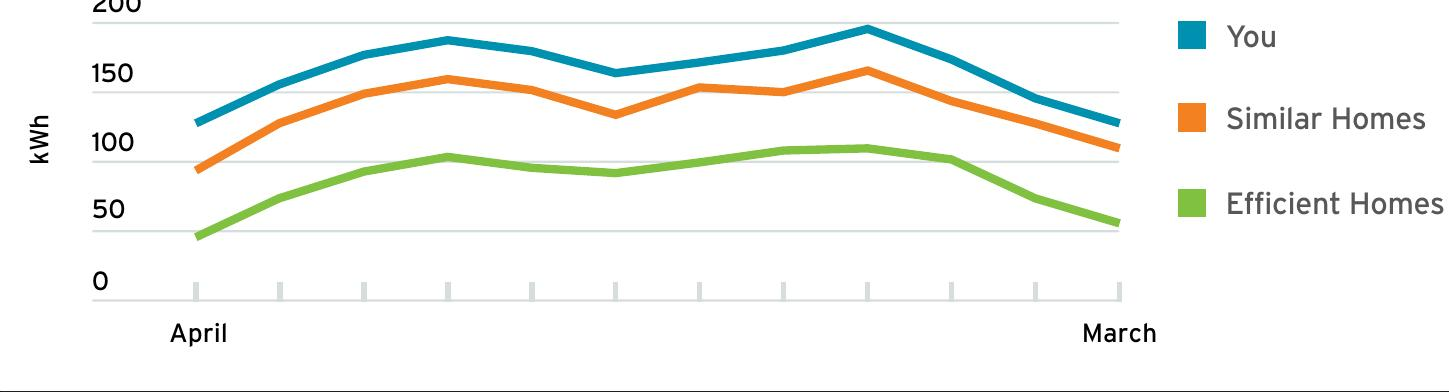

In [19]:
display_base64_image(retriever.invoke("Image of graph containing elecricity consumption?")[0])

Seems like we got our graph and the vector store is returning the top document associated with our query.

---

## Full RAG with Ollama (gemma3) Question and Answering

This defines a LangChain-style RAG pipeline for LLM question answering. It retrieves relevant documents from the vector store using the user’s question, parses the retrieved content (`parse_docs`), constructs a prompt (`build_prompt`), and sends it to an Ollama-hosted LLM (OllamaLLM). The final answer is then parsed into a string using `StrOutputParser()`. The use of `RunnableLambda` and `RunnablePassthrough()` allows flexible chaining of custom functions and inputs in the LangChain pipeline. I set the LLM's `tempreture` param to 0 for the output to be consistent on repeated runs.

In [20]:
chain_llm_questions = {
    "context": retriever | RunnableLambda(parse_docs),
    "question": RunnablePassthrough(),
} | RunnableLambda(build_prompt) | OllamaLLM(
    model=ollama_model_name,
    temperature=0,
) | StrOutputParser()

In the section below we will be assessing the performance of our makeshift RAG solution with a few questions based on our PDF.

### Q1: What is the customer name, address and account id?

In [21]:
display(Markdown(chain_llm_questions.invoke("What is the customer name, address, month cycle and account id?")))

Here’s the information based on the provided context:

*   **Customer Name:** JILL DOE
*   **Service Address:** 1627 Tulip Lane
*   **Month Cycle:** March
*   **Account ID:** 954137

---

Our RAG solution did well on this extract! The information perfectly aligns what is in the PDF!

<img src="diagrams/customer.png" width="400"/>

### Q2: What is my electricity usage this cycle in kWh?

In [22]:
display(Markdown(chain_llm_questions.invoke("What is my electricity usage this cycle in kWh?")))

Your electric use: 18% more than similar nearby homes 125 kWh

---

Quite close but not quite. I was expecting here that the RAG solution would just say the customer consumed 125 kWh. It seems that in this generation it hallucinated a bit.

<img src="diagrams/consumption.png" width="400"/>

### Q3: What are some tips for saving electricity?

In [23]:
display(Markdown(chain_llm_questions.invoke("What are some tips for saving electricity?")))

Here are the tips for saving electricity based on the provided text:

*   Do full laundry loads.
*   Caulk windows and doors.
*   Charge your EV overnight (Rates are lower after 9pm).
*   Look for an Energy Star label.
*   Adjust thermostat settings.
*   Pre-heat your home on cold days.

---

Our RAG solution also did well here it matched with the suggestions in our PDF document and some generally good tips augmented from the LLM.

<img src="diagrams/laundry.png" width="200"/><img src="diagrams/tips.png" width="500"/><img src="diagrams/audit.png" width="500"/>

### Q4: How do I compare to other nearby homes in kwh consumption?

In [24]:
display(Markdown(chain_llm_questions.invoke("How do I compare to other nearby homes in kwh consumption?")))

According to the report, you used 18% more than similar nearby homes. Your similar nearby homes used 125 kWh, and efficient nearby homes used 103 kWh and 49 kWh.

---

Our RAG solution almost made it here. It incorrectly associated 125 kWH usage to similar nearby homes instead of it being our consumption and associated the 2 values (103 kWh and 49 kWh) for efficient nearby homes. Only 49 kWh should be associated with efficient nearby homes and 103 kWh should have been associated with similar nearby homes. Unfortunately this one also hallucinated a bit.

<img src="diagrams/consumption.png" width="400"/>

---

## Learnings, Challenges and Suggestions

### Learnings

I have only come across RAG pipeline creation in my Natural Language Processing Subject in my Masters and most of the implementations we have made are mostly textual data coming from txt files, arxiv 